# Machine Learning 1: Prácticas

Roberto Yubero de Diego

2020

# Índice

1. Introducción
2. Técnicas de reducción de la dimensionalidad
    + PCA 
    + MDS
    + UMAP 
    + Resumen de resultados útiles para posteriores tareas
3. Aprendizaje no supervisado
    + K-Means 
    + Spectral clustering 
4. Aprendizaje supervisado & ajúste de hiperparámetros
    + GLM 
    + KNN 
5. Comparativa y selección de modelos
    + GLM vs KNN

## 1. Introducción

La presente práctica busca estimar si un video publicado en la plataforma TED Talks  será muy visto o no. Para ello, se utilizará un conjunto de datos que contiene las siguientes características:

+ `COMMENTS`: variable numérica que representa numero de comentarios que ha tenido un vídeo
+ `DURATION`: variable numérica que representa la duración en minutos del vídeo
+ `LANGUAGES`: variable numérica que indica el número de lenguajes a los que se ha traducido el vídeo
+ `SPEAKER TALKS`: variable numérica que indica el número de charlas que ha dado el orador
+ `PUBLISHED_MONTH`: variable numérica que indica el mes de publicación
+ `PUBLISHED_YEAR`: variable numérica que indica el año de publicación
+ `GENERAL_OPINION`: variable categórica que indica la opinión general de los espectadores que han valorado la charla. Tres posibles valores: "positive", "neutral" y "negative".
+ `SPEAKER_POP`: variable categórica que indica la popularidad de un orador. Dos posibles valores: "very_popular", "popular" y "not_popular".
+ `EVENT`: variable categórica que indica el nombre del evento en el que se desarrolló la charla.
+ `LOCATION`: variable categórica que indica la localización donde se desarrolló la charla.
+ `TAGS`: variable categórica que indica los temas asociados a la charla.
+ `VIEWS`: variable numérica que indica el número de visualizaciones que tuvo un vídeo.
+ `VIEWS_CATEGORICAL`: **variable respuesta** . Variable categórica que indica si el vídeo ha tenido muchas o pocas visitas con los valores "popular_video" y "not_popular_video" respectivamente. Un vídeo se ha considerado que es popular cuando supera el 75% de las visualizaciones de la muestra de entrenamiento (1.75 Millones de visitas).


In [8]:
import utils as  # user defined functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import umap
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
import sklearn.metrics as skm
import pickle

%config InlineBackend.figure_format ='retina'  # ipython configuration to improve plots resolution
%matplotlib inline

In [3]:
# load train and validation data
data_path = './data'

train_views = pd.read_csv(data_path + '/df_train.csv')['views']
# threshold to convert views in categorical. If above threshold then video is 'popular_video', otherwise video is 'not_popular_video'
th = np.quantile(train_views, 0.75)

df_train = u.read_processing(data_path + '/df_train.csv', threshold=th)
df_test = u.read_processing(data_path + '/df_validation.csv', threshold=th)

df_train.head(3)

,COMMENTS,DURATION,LANGUAGES,SPEAKER_TALKS,PUBLISHED_YEAR,PUBLISHED_MONTH,GENERAL_OPINION,SPEAKER_POP,EVENT,LOCATION,TAGS,VIEWS,VIEWS_CATEGORICAL
0,4553,1164,60,5,2006,6,positive,very_popular,TED,Other,"['children', 'creativity', 'culture', 'dance',...",47227110,popular_video
1,265,977,43,4,2006,6,positive,popular,TED,Other,"['alternative energy', 'cars', 'climate change...",3200520,popular_video
2,124,1286,26,5,2006,6,positive,very_popular,TED,Other,"['computers', 'entertainment', 'interface desi...",1636292,not_popular_video


## 2. Técnicas de reducción de la dimensionalidad

### 2.1. PCA

Se estandarizan las variables nuiméricas antes de aplicar PCA. 
Al tener tan solo 4 variables numéricas, se calculan unicamente las 4 primeras componentes principales.


In [4]:
# estandarizacion (media 0 dev.tipica 1) de los valores numericos del df
df = df_train
n_numeric_cols = sum(df.dtypes == int) - 1      # -1 used to avoid target variable influence
numeric_columns = [i for i in range(0, n_numeric_cols)]
vals = StandardScaler().fit_transform(df.iloc[:, numeric_columns])
df_standarised = pd.DataFrame(vals, columns=df.columns[numeric_columns])

#..............................................
# obtencion de componentes principales
#..............................................
pca = PCA(n_components=n_numeric_cols)
values = pca.fit_transform(df_standarised)
components_names = ['PC' + str(i+1) for i in numeric_columns]
df_pca = pd.DataFrame(values, columns=components_names)
# Show ratios of information per component
ratios = pca.explained_variance_ratio_
print("Ratios of variance for components \n{}\n{}".format(components_names, [round(ratio, 2) for ratio in ratios]))

Ratios of variance for components 
['PC1', 'PC2', 'PC3', 'PC4']
[0.37, 0.29, 0.24, 0.1]


Mostramos como se ha calculado cada componente principal (en valor absoluto).

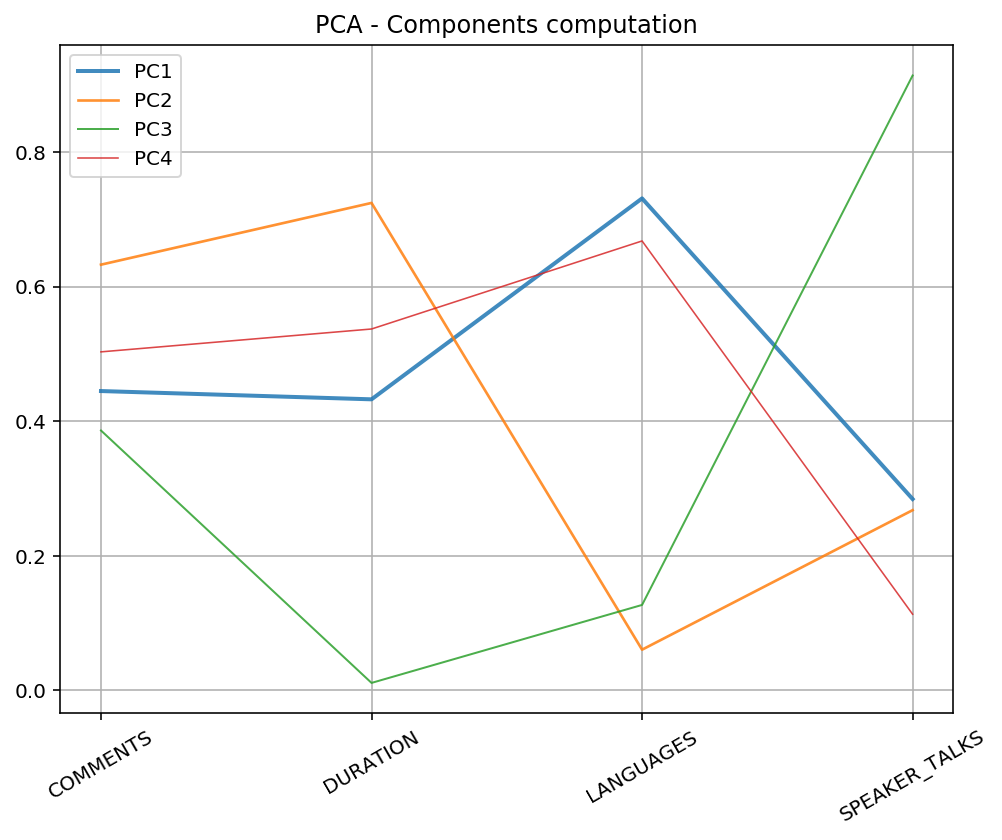

In [5]:
components = pca.components_
original_features = df_standarised.columns.tolist()

u.pca_line_plot(components, original_features, title=" - Components computation", figsize=(8, 8))

Se observa que las variables numéricas que aportan mayor cantidad de información son: `languages` (para PC1) y `comments`, `duration` (para PC2).

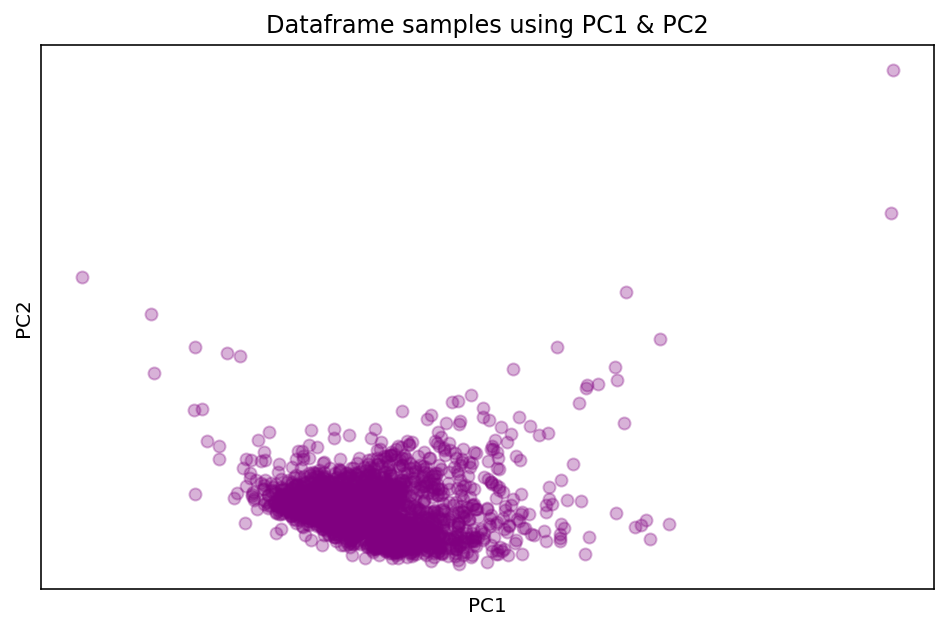

In [6]:
plt.figure(figsize=(8, 5))
plt.scatter(df_pca.loc[:, 'PC1'], df_pca.loc[:, 'PC2'], alpha=0.3, c='purple')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Dataframe samples using PC1 & PC2")
plt.xticks([])
plt.yticks([]);

 Se observa que hay una maraña de puntos y que el resultado del PCA no permite diferenciar grupos de forma clara.
 Se va a colorear en función de las diferentes categorías para cada una de las variables categóricas.

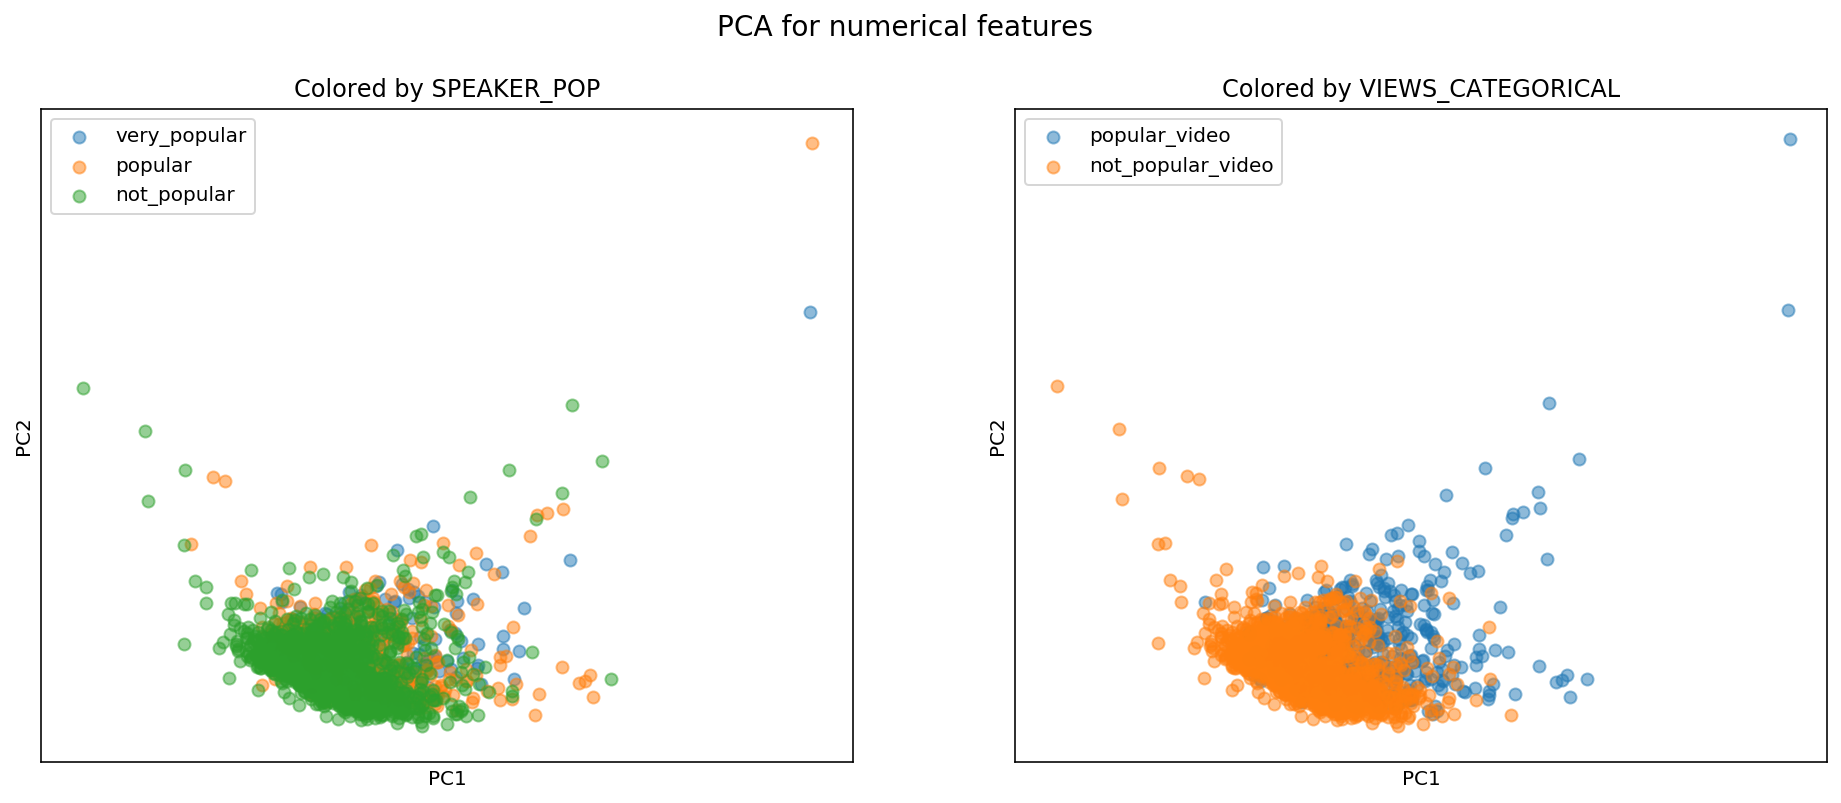

In [7]:
u.color_by_category(df_pca, df.loc[:, ['SPEAKER_POP', 'VIEWS_CATEGORICAL']], nrows=1, ncols=2, figsize=(16,6),
                   sup_title="PCA for numerical features")

Se observa que con la reducción de la dimensionalidad podrían llegar a separarse las charlas "popular_video" de las
"not_popular_video", pues una frontera diagonal podría separarlas de forma clara.

### 2.2. MDS

El escalado multidimensional (MDS) es una técnica de reducción de la dimensionalidad donde se busca reducir el numero de características originales, respetando la distancia entre las muestras. A diferencia de PCA, las distancias entre muestras se corresponden al valor obtenido según la métrica aplicada.

Esta técnica se ha aplicado únicamente sobre las variables numéricas (previamente estandarizadas), tal y como se hizo con PCA.


In [9]:
mds_reduction = MDS(n_components=2, random_state=123)
values = mds_reduction.fit_transform(df_standarised)
df_mds = pd.DataFrame(values, columns=['MDS-C1', 'MDS-C2'])

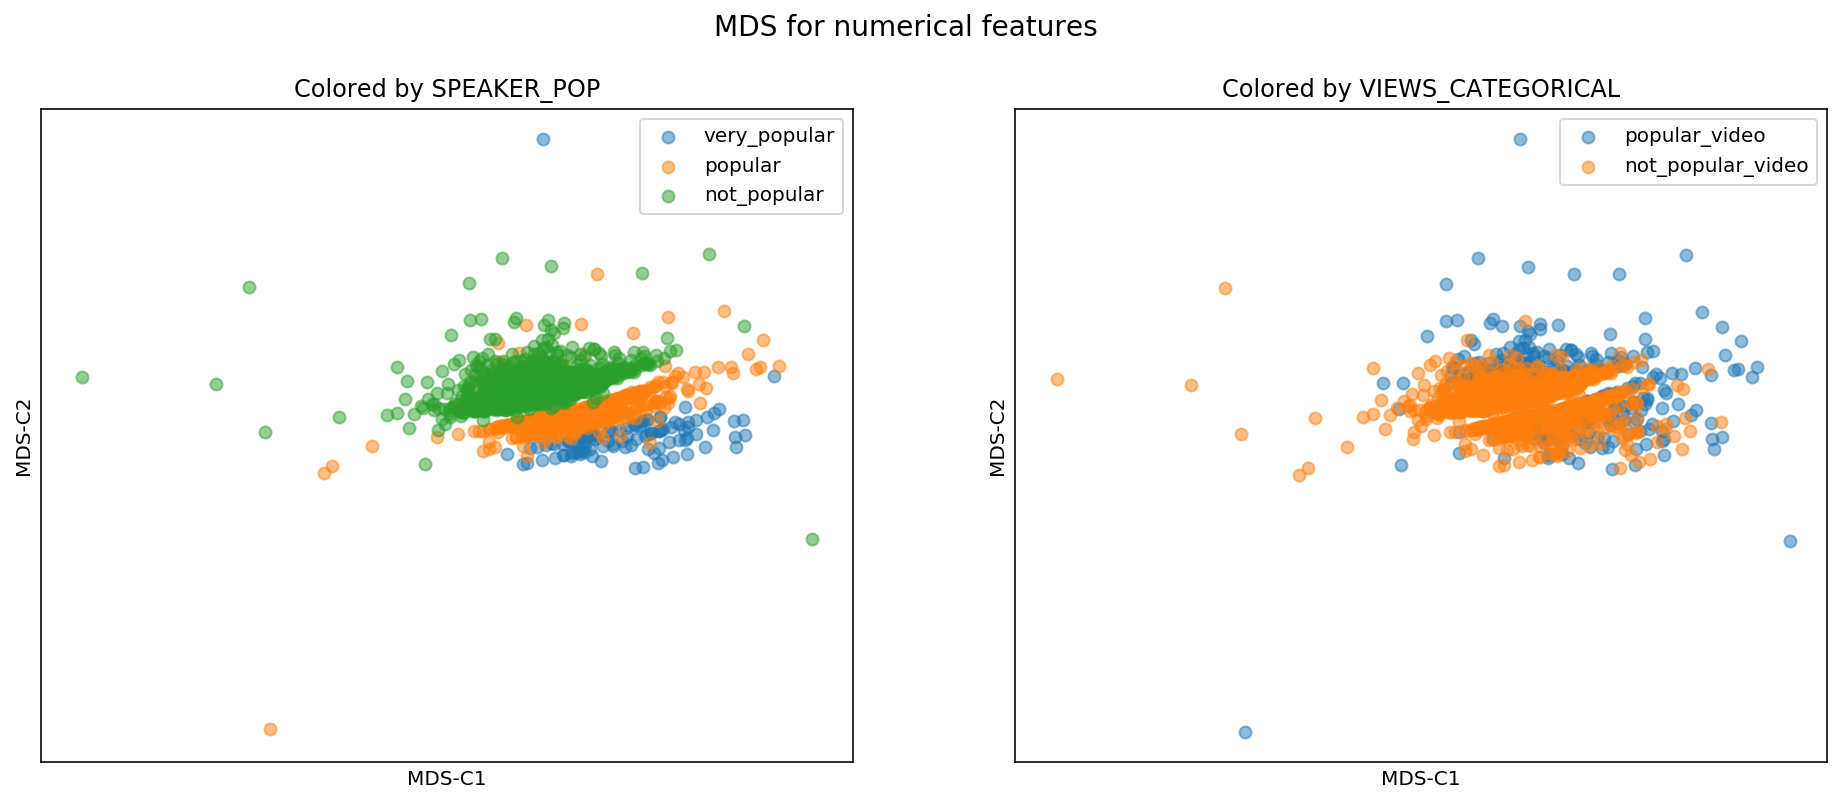

In [10]:
u.color_by_category(df_mds, df.loc[:, ['SPEAKER_POP', 'VIEWS_CATEGORICAL']], nrows=1, ncols=2, figsize=(16,6),
                    sup_title="MDS for numerical features")

Se observa que la catgorías de la variable respuesta `VIEWS_CATEGORICAL` están más mezcladas que en el caso de utilizar PCA. De este modo, las técnicas de clustering para esta variable utilizarán la reducción de la dimensionalidad previamente obtenida con PCA.

### 2.3. UMAP

Este algoritmo, a diferencia de PCA, tiene parámetros configurables, se enumeran a continuación:
- **n_neighbors**: detecta estructuras locales. Valor alto, detecta estructuras globales de todo el conjunto de datos. Valor por defecto: 15. Valor alto, en torno al 25% de las muestras utilizadas.
- **min_dist**: valores ente [0, 1]. Los valores bajos favorecen la generación de grupos marcados. Útil para clustering.
- **n_components**: número de componentes a calcular. Por defecto: 2.
- **metric**: metrica utilizada para calcular distancias. Numerosas opciones, 'euclidian' por defecto



Se ha jugado con los valores de los diferentes parámetros (modificando los valores de **n_neighbors** (valores: 0.25, 0.5 y 0.75) y **min_dist** ( valores; 0, 0.4, 0.8, 0.9)), sin lograr poder distinguir grupos de forma clara. A continuación se muestra el resultado obtenido al utilizar los parámtros por defecto.

Valores por defecto: n_neighbors = 15, min_dist = 0.1, n_components = 2, metric = 'euclidean'

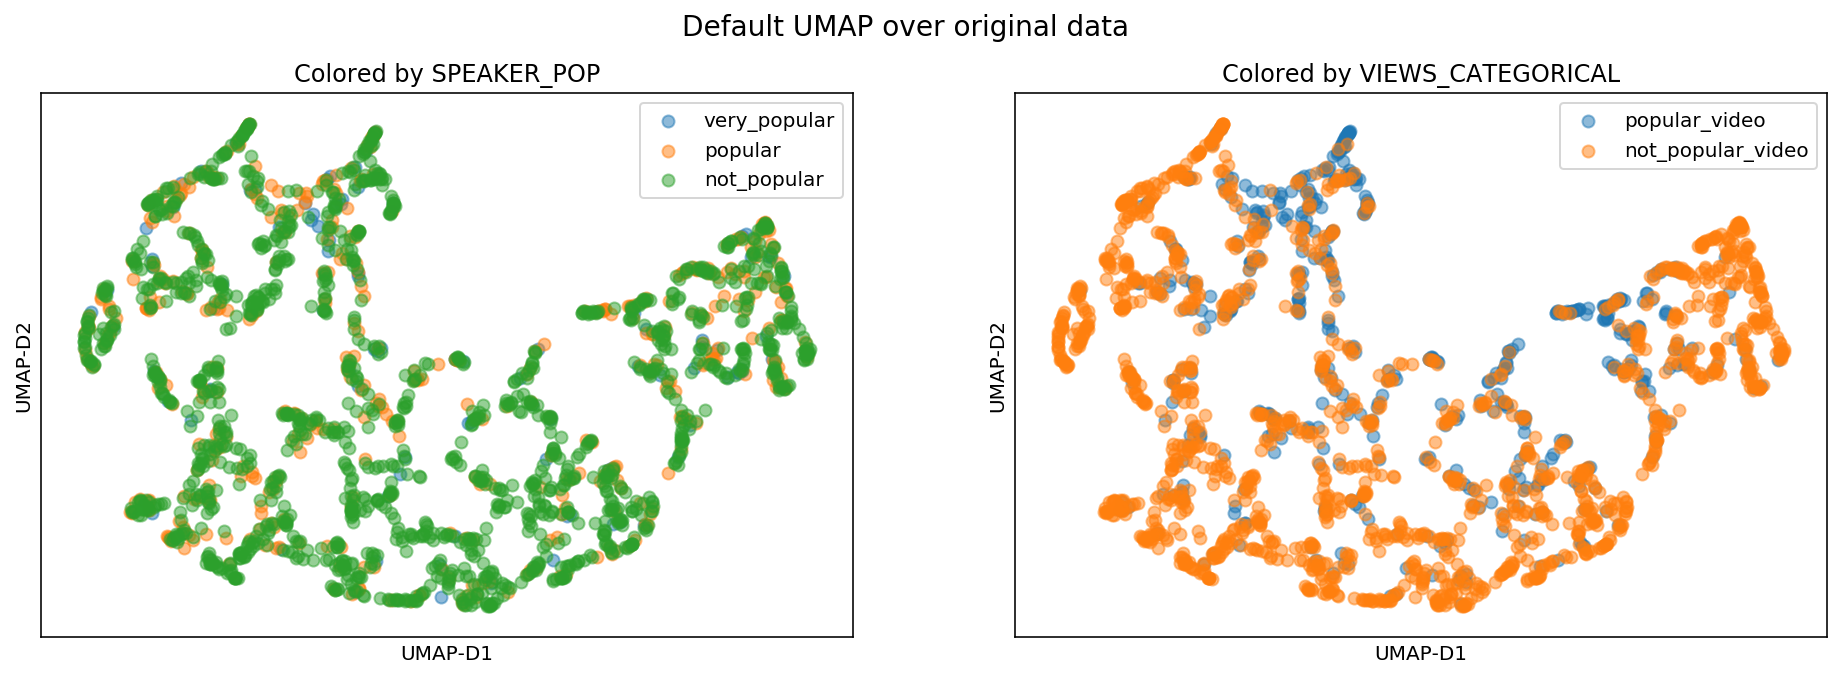

In [11]:
# UMAP over original data (df)
umap_vals = umap.UMAP().fit_transform(df.iloc[:, numeric_columns])
df_umap = pd.DataFrame(umap_vals, columns=['UMAP-D1', 'UMAP-D2'])
u.color_by_category(df_umap, df.loc[:, ['SPEAKER_POP', 'VIEWS_CATEGORICAL']],figsize=(16, 5), nrows=1, ncols=2,
                   sup_title='Default UMAP over original data')

Sin embargo, se prueba a aplicar el algoritmo sobre las variables numéricas estandarizadas mediante `df_standarised` y se observan resultados interesantes.

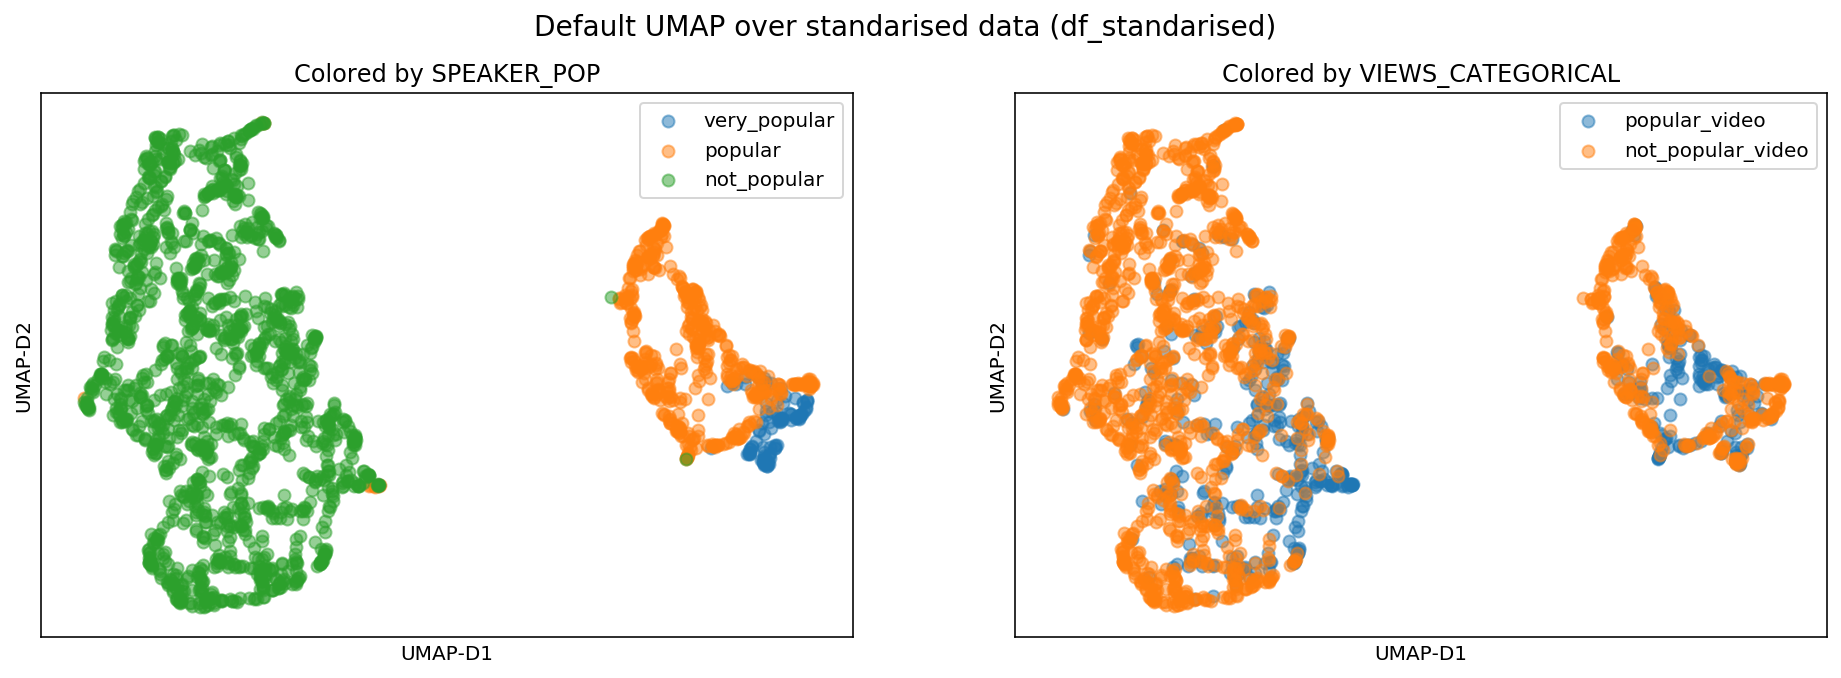

In [12]:
umap_vals = umap.UMAP().fit_transform(df_standarised)
df_umap = pd.DataFrame(umap_vals, columns=['UMAP-D1', 'UMAP-D2'])
u.color_by_category(df_umap, df.loc[:, ['SPEAKER_POP', 'VIEWS_CATEGORICAL']], nrows=1, ncols=2,
                    sup_title='Default UMAP over standarised data (df_standarised)', figsize=(16, 5))

Si se quisiera categorizar un ponente según su popularidad (gráfico de la izquierda), podrían discriminarse dos grupos sin problemas.

### 2.5. Resultados de utilidad obtenidos tras reducción de la dimensionalidad
A continuación se muestran los resultados que, tras aplicar técnicas de reducción de la dimensionalidad, se han considerado útiles para posteriores tareas como: aplicación de algoritmos de aprendizaje supervisado y no supervisado. Dichos resultados son:

- MDS (`df_mds`): se visualiza según la variable respuesta `VIEWS_CATEGORICAL`
- PCA (`df_pca`): se visualiza según la variable respuesta `VIEWS_CATEGORICAL`
- UMAP (`df_umap`): se visualiza según la variable `SPEAKER_POP`

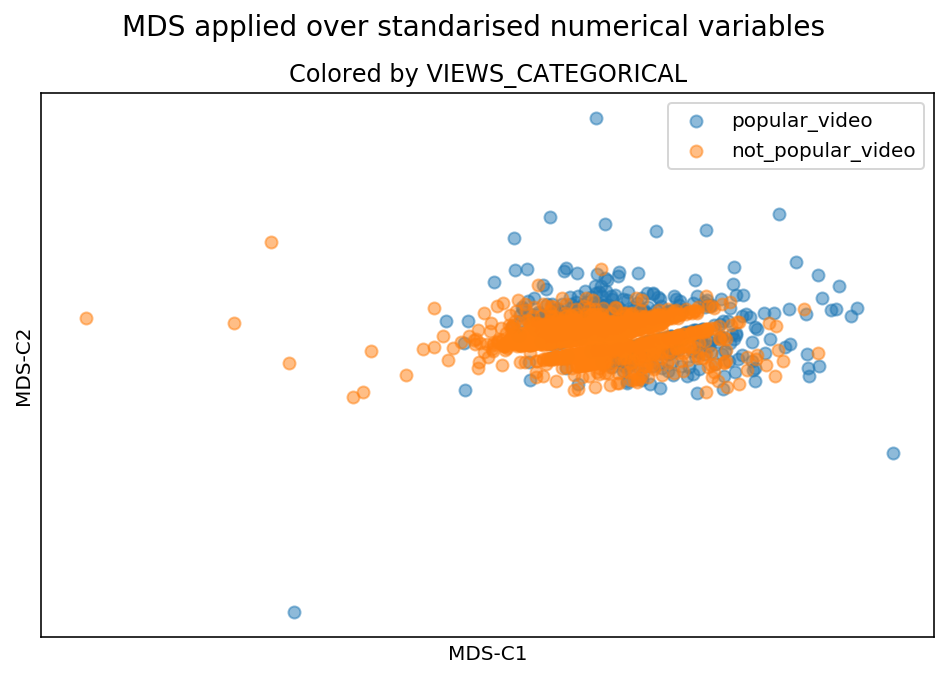

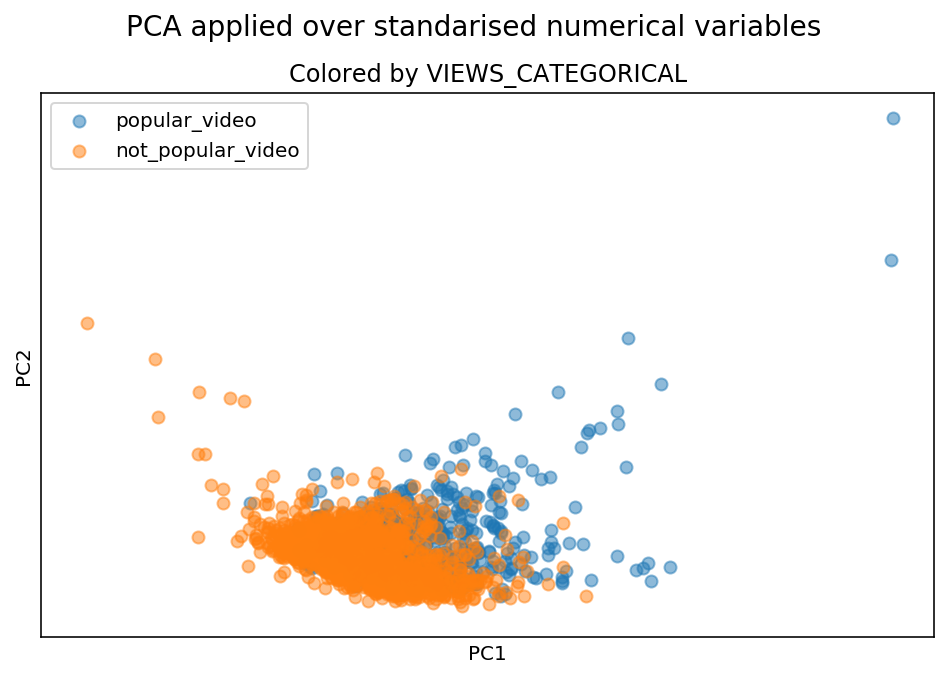

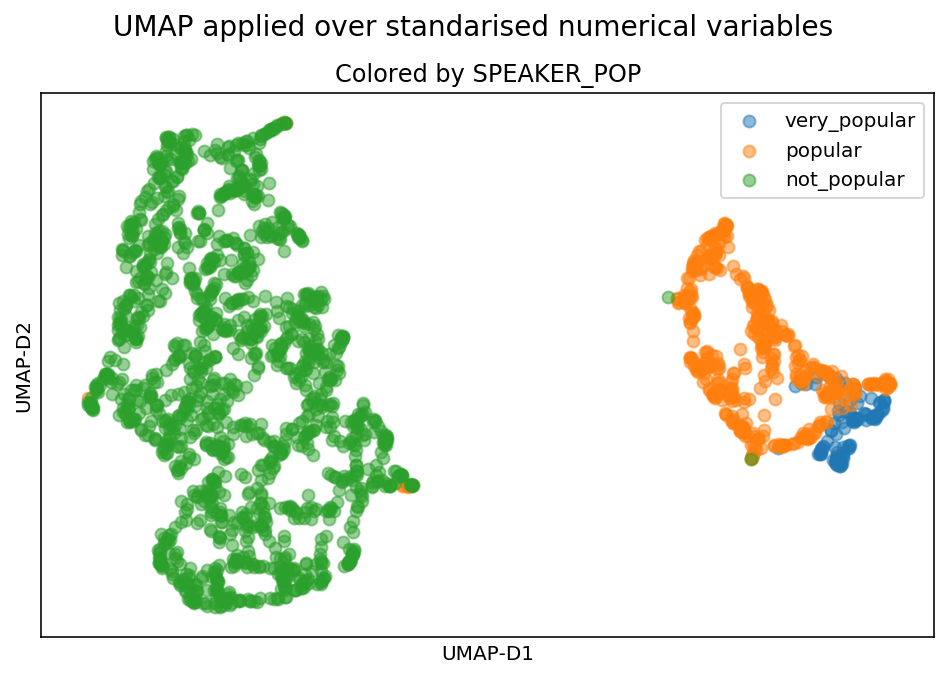

In [15]:
# MDS
u.color_by_category(df_mds, df.loc[:, ['VIEWS_CATEGORICAL']], nrows=1, ncols=1, figsize=(8, 5),
                    sup_title="MDS applied over standarised numerical variables")

# PCA
u.color_by_category(df_pca, df.loc[:, ['VIEWS_CATEGORICAL']], nrows=1, ncols=1, figsize=(8, 5),
                    sup_title='PCA applied over standarised numerical variables')

# UMAP 
u.color_by_category(df_umap, df.loc[:, ['SPEAKER_POP']], nrows=1, ncols=1, figsize=(8, 5),
                    sup_title='UMAP applied over standarised numerical variables')

El resultado obtenido con **PCA agrupa de forma más diferenciada la variable respuesta `VIEWS_CATEGORICAL`.**

## 3. Aprendizaje no supervisado

Las técnidas de aprendizaje no supervisado que se van a aplicar son las siguientes:

+ 3.1. K-Means: 
    + Para variable `VIEWS_CATEGORICAL` utilizando el resultado de PCA
    + Para variable `SPEAKER_POP` utilizando el resultado de UMAP
+ 3.2. Spectral clustering: 
    + Para variable `VIEWS_CATEGORICAL` utilizando el resultado de PCA
    + Para variable `SPEAKER_POP` utilizando el resultado de UMAP

### 3.1. K-Means

Se aplica K-Means sobre `df_pca` con intención de dividir la variable `VIEWS_CATEGORICAL` en dos grupos. Para ello se utilizan, de **PCA**, las componentes PC1 y PC2 y se configua el algoritmo para que detecte dos clusters.

#### K-Means sobre resultado de aplicar PCA

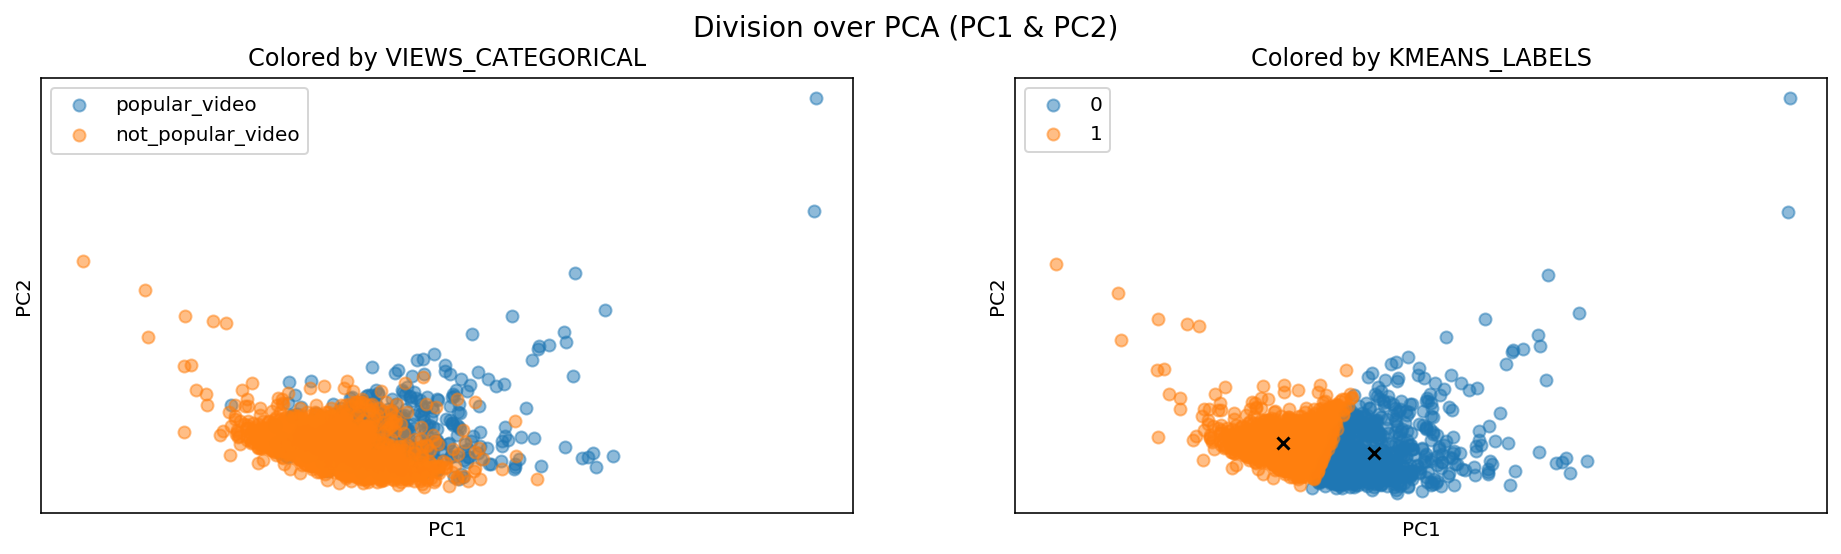

In [16]:
variables = ['PC1', 'PC2']
kmeans = KMeans(n_clusters=2, random_state=123).fit(df_pca[variables])
spectral = SpectralClustering(n_clusters=2, random_state=123).fit(df_pca[variables])

# styling & plot
labels_kmeans = pd.DataFrame(kmeans.labels_, columns=['KMEANS_LABELS'])
labels_df = pd.concat([df[['VIEWS_CATEGORICAL']], labels_kmeans], axis=1)
u.color_by_category(df_pca[variables], labels_df, nrows=1, ncols=2, sup_title='Division over PCA (PC1 & PC2)', figsize=(16, 4))

# add centroids
for centroid in kmeans.cluster_centers_:
    plt.scatter(centroid[0], centroid[1], marker='x', c='black')

Se observa que la división es poco precisa. Se opta por **incrementar el número de clusters** y evaluar como cambian los valores de recall y de tpr con **nuevas reagrupaciones seleccionadas por el usuario**.

La siguiente curva muestra como ha evolucionado el valor de **recall** y **tpr** para **diferentes valores de k**, en particular valores entre 2 y 13, ambos incluidos.

2 0
7 5


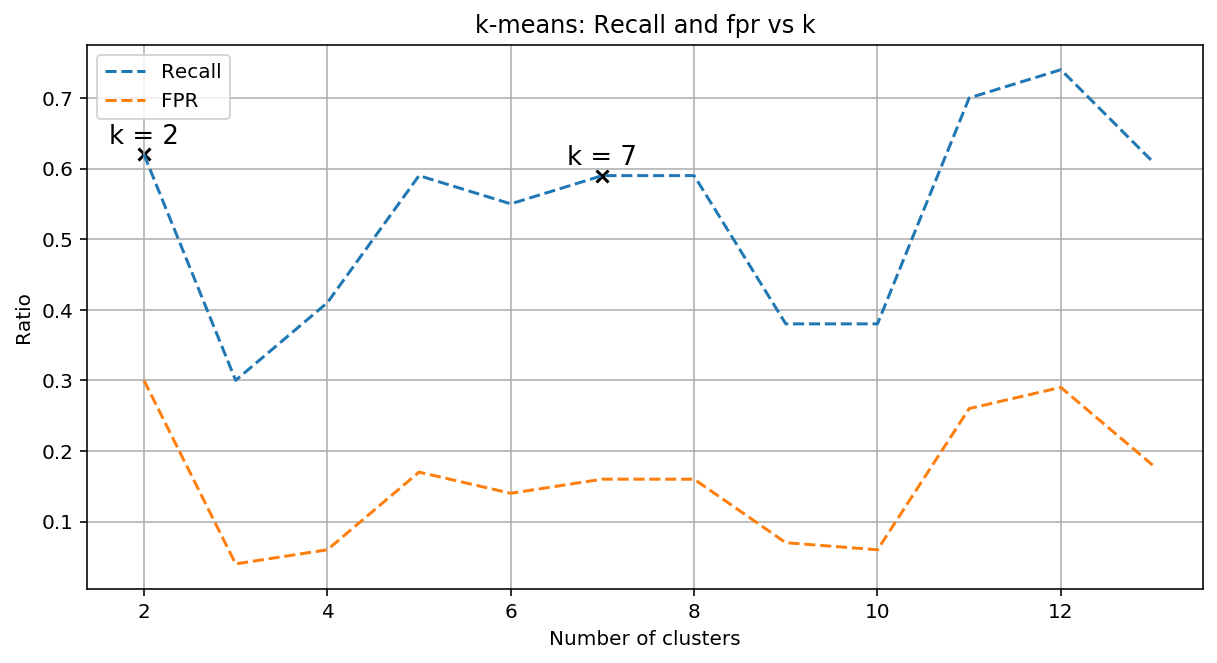

In [17]:
# clusters to be joined for each selected k. Those cluseters stored in 'target_clusters' will be joint in order to
# improve target variable division
target_clusters = {2: [0], 3: [2], 4: [3, 0], 5: [0, 2, 4], 6: [2, 3, 4], 7: [2, 3, 4, 6], 8: [1, 2, 4, 5],
                    9: [1, 3, 4, 7], 10: [0, 3, 4, 6],  11: [0, 3, 4, 7, 8, 9], 12: [2, 3, 4, 5, 7, 8, 10],
                    13: [0, 2, 3, 4, 6, 10, 12]}
clusters = {}
for n in range(2, 14):
    n_clusters = n
    kmeans = KMeans(n_clusters=n_clusters, random_state=123).fit(df_pca[variables])
    labels_kmeans = pd.DataFrame(kmeans.labels_, columns=['KMEANS_LABELS'])

    mapping = u.get_labels_mapping(target_clusters[n_clusters], n_clusters)
    labels_kmeans_mapped = labels_kmeans.copy().replace(mapping)

    #  prepare labels_df
    labels_kmeans_mapped.columns = ['KMEANS_LABELS_MAPPED']
    labels_df = pd.concat([labels_kmeans, labels_kmeans_mapped], axis=1)

    # compute recall and fpr
    mapping_y = {"not_popular_video": 0, "popular_video": 1}
    y_target = df['VIEWS_CATEGORICAL'].copy().replace(mapping_y).values
    y_pred = labels_kmeans_mapped['KMEANS_LABELS_MAPPED'].copy().values
    recall, fpr = u.get_recall_fpr(y_target, y_pred)
    # store metrics
    clusters[n] = {'recall': recall, 'fpr': fpr, 'kmeans_labels': kmeans.labels_,
              'centroids': kmeans.cluster_centers_, 'grouped_labels': y_pred}

u.plot_kmeans_comparison(clusters, figsize=(10, 5), kmarkers=[2, 7])


Se observa que con k entre 5 y 8 **se estabiliza el valor de recall** y se obtienen unos **valores de fpr claramente menores** que usando k = 2.

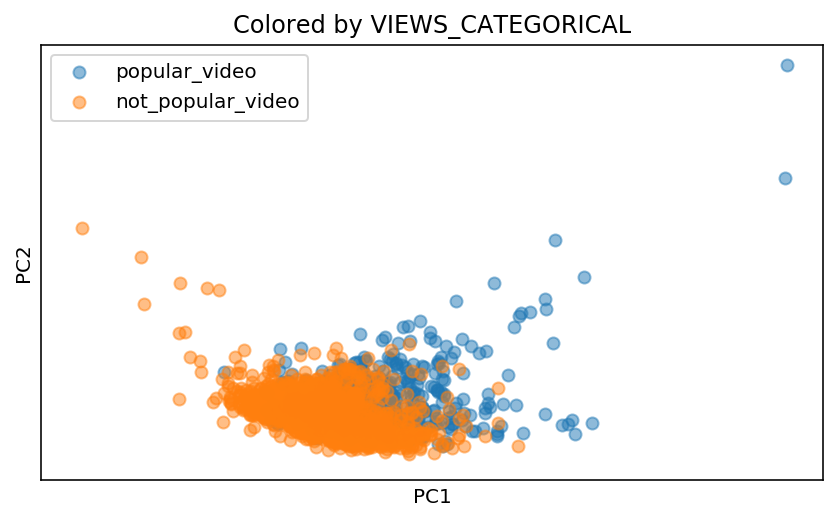

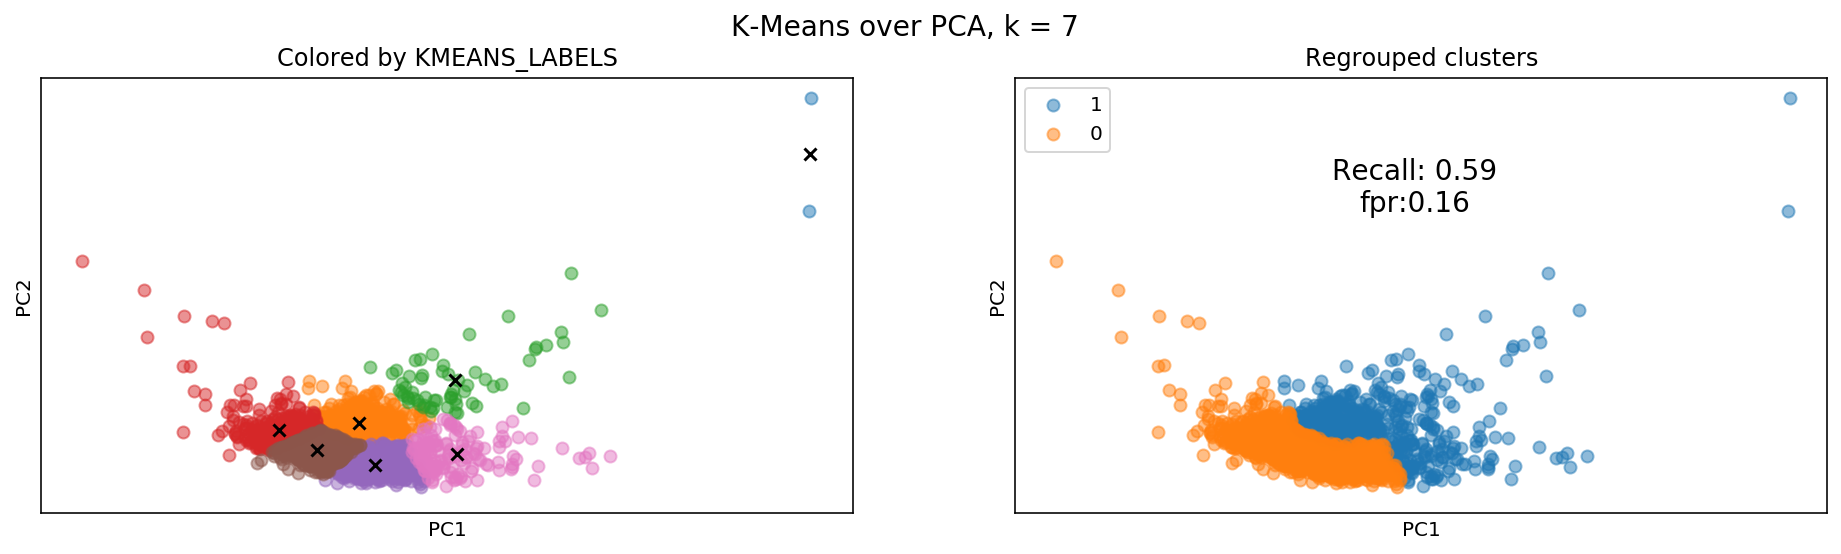

In [18]:
u.color_by_category(df_pca, df.loc[:, ['VIEWS_CATEGORICAL']], nrows=1, ncols=1, figsize=(7, 4))
u.plot_kmeans(clusters[7], 7, df_pca.loc[:, ['PC1', 'PC2']])

**Esta implementación (k = 7 con posterior reagrupación de clusters) ha mejorado los resultados respecto a la original (k = 2).** Se observa que el valor de recall es muy similar, pero el fpr logrado es la mitad (ver imagen anterior: 'k-means: Recall and fpr vs k').

### 3.2. Spectral clustering
Se ejecuta el algoritmo sobre los mismos casos que para kmeans.
Para el caso de **PCA**, los resultados que aporta spectral clustering son peores.

Spectral clustering sobre `df_pca` con intención de dividir la variable `VIEWS_CATEGORICAL` en dos grupos. Para ello se utilizan, de **PCA**, las componentes PC1 y PC2 y se configua el algoritmo para que detecte dos clusters.

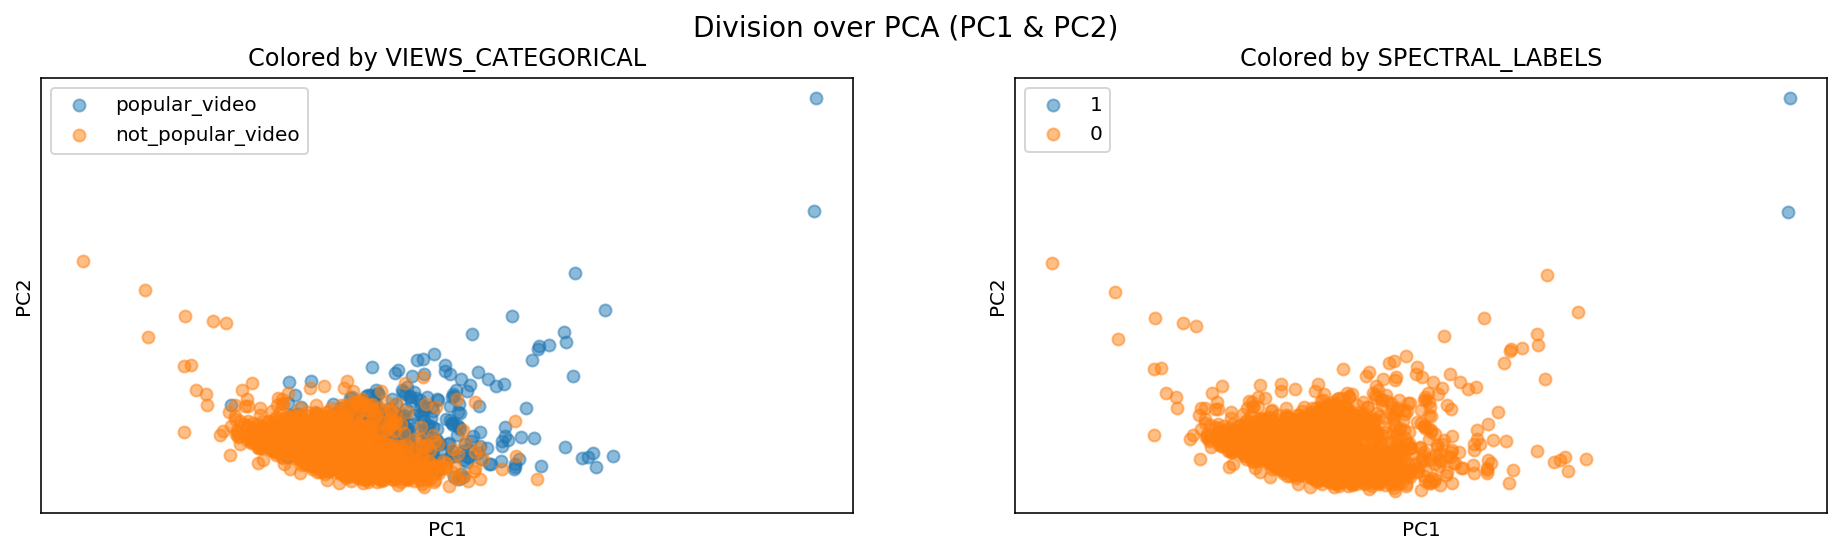

In [20]:
variables = ['PC1', 'PC2']
spectral = SpectralClustering(n_clusters=2, random_state=123).fit(df_pca[variables])

# styling
labels_spectral = pd.DataFrame(spectral.labels_, columns=['SPECTRAL_LABELS'])
labels_df = pd.concat([df[['VIEWS_CATEGORICAL']], labels_spectral], axis=1)
# plot comparison
u.color_by_category(df_pca[variables], labels_df, nrows=1, ncols=2, sup_title='Division over PCA (PC1 & PC2)', figsize=(16, 4))

## 4. Aprendizaje supervisado & ajuste de hiperparámetros

### 4.1. KNN

La base de knn es el uso de distancias para identificar cuales son los vecinos más proximos a la muestra de la que se quiere predecir su valor o categoría.

El conjunto de datos utilizado tiene tanto variables numércias como categóricas por lo que habrá que hacer tratamiento de las variables para que el cómputo de las distancias sea correcto.

El tratamiento realizado sobre las observaciones para permitir el cómputo de distancias ha sido el siguiente:

1. **Variables numéricas**:    
    + Normalización de sus valores en el rango [0, 1]
    
    
2. **Variables categóricas**:    
    + Generación de variables dummy mediante la metodología on-hot encoding
    + Adicionalmente, se ha aplicado un escalado a las variables dummy el cual ha mejorado los resultados obtenidos al aplicar KNN
    


In [51]:
# PREPARACIÓN DE DATOS

df_train = u.read_processing(data_path + '/df_train.csv', threshold=th)
df_test = u.read_processing(data_path + '/df_test.csv', threshold=th)

# TRAIN: Convert features (numeric + categorical)

# convert categorical features using one-hot encoding
df_categorical = df_train.loc[:, ['GENERAL_OPINION', 'SPEAKER_POP', 'EVENT']]
oh_enc = OneHotEncoder()
values = oh_enc.fit_transform(df_categorical).toarray().astype(int)
df_categorical = pd.DataFrame(values, columns= u.get_new_names(df_categorical.columns, oh_enc.categories_))
# normalise numerical and join with categorical data already converted
df_numeric = df_train.iloc[:, numeric_columns]
df_norm_train = u.normalise_dataframe(df_numeric, df_categorical)

X_train = df_norm_train.copy()
y_train = df_train.loc[:, ['VIEWS_CATEGORICAL']]


# TEST: Convert features (numeric + categorical)

df_categorical = df_test.loc[:, ['GENERAL_OPINION', 'SPEAKER_POP', 'EVENT']]
values = oh_enc.transform(df_categorical).toarray().astype(int)
df_categorical = pd.DataFrame(values, columns=u.get_new_names(df_categorical.columns, oh_enc.categories_))
# normalise numerical and join with categorical data already converted
df_numeric = df_test.iloc[:, numeric_columns]
df_norm_test = u.normalise_dataframe(df_numeric, df_categorical)

X_test = df_norm_test.copy()
y_test = df_test.loc[:, ['VIEWS_CATEGORICAL']]

# convert strings to numbers to performe metrics computation
mapping_y = {'not_popular_video':0, 'popular_video': 1}
y_test = y_test.replace(mapping_y)

El resultado obtenido tras aplicar los pasos enumerados (sin aplicar el paso adicional) son:

In [52]:
X_train.head(3)

,COMMENTS,DURATION,LANGUAGES,SPEAKER_TALKS,GENERAL_OPINION-negative,GENERAL_OPINION-neutral,GENERAL_OPINION-positive,SPEAKER_POP-not_popular,SPEAKER_POP-popular,SPEAKER_POP-very_popular,EVENT-Other,EVENT-TED,EVENT-TEDGlobal,EVENT-TEDx
0,0.710555,0.200937,0.826087,0.571429,0,0,1,0,0,1,0,1,0,0
1,0.040031,0.164421,0.579710,0.428571,0,0,1,0,1,0,0,1,0,0
2,0.017983,0.224761,0.333333,0.571429,0,0,1,0,0,1,0,1,0,0


Tras convertir las variables se aplica KNN con k = 5, distancia euclidea y ponderación según distancia.

In [53]:
# Apply KNN (n = 5 + distance weighting)
# train model
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance').fit(X_train, y_train.values.ravel())
pred_values = clf_knn.predict(X_test)
y_pred_knn = pd.DataFrame(pred_values, columns=y_train.columns)
y_pred_knn = y_pred_knn.replace(mapping_y)

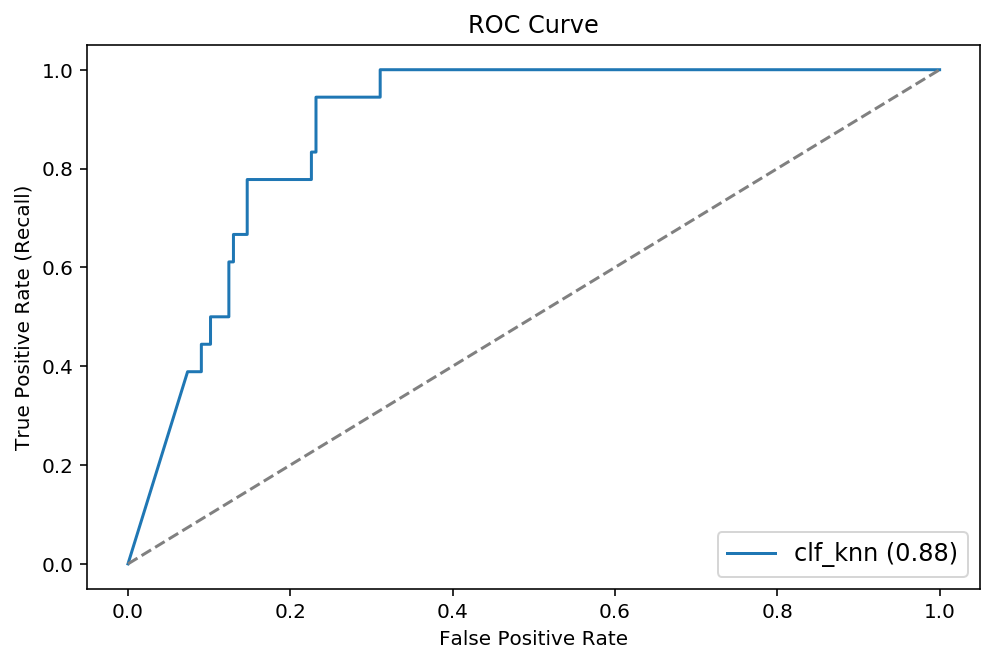

In [54]:
# store model
models = {}
models['clf_knn'] = {'clf': clf_knn, 'X_test': X_test, 'y_pred': y_pred_knn}

# get metrics for requested models and plot their ROC curve/curves
models_metrics = u.get_ROC_metrics(models, y_test)
u.plot_ROC(models_metrics, figsize=(8, 5))

El resultado es aceptable aunque los datos utilizados no terminan de ser correctos. 
Al utilizar one-hot encoding las variables categóricas darán distancias de 0 cuando coincidas y de 1 cuando no. Esto son valores extremos que rara vez ocurrirán con las variables numércias. Por decirlo de otro modo, las variables categóricas (dummies) recogen mucha mayor variabilidad que las numéricas. 

Este comportamiento puede verse al aplicar PCA sobre estos datos, donde puede observarse que en el cálculo de las componentes PC1 y PC2 no apenas intervienen las variables numércicas (`COMMENTS`, `DURATION`, `LANGUAGES` y `SPEAKER_TALKS`)


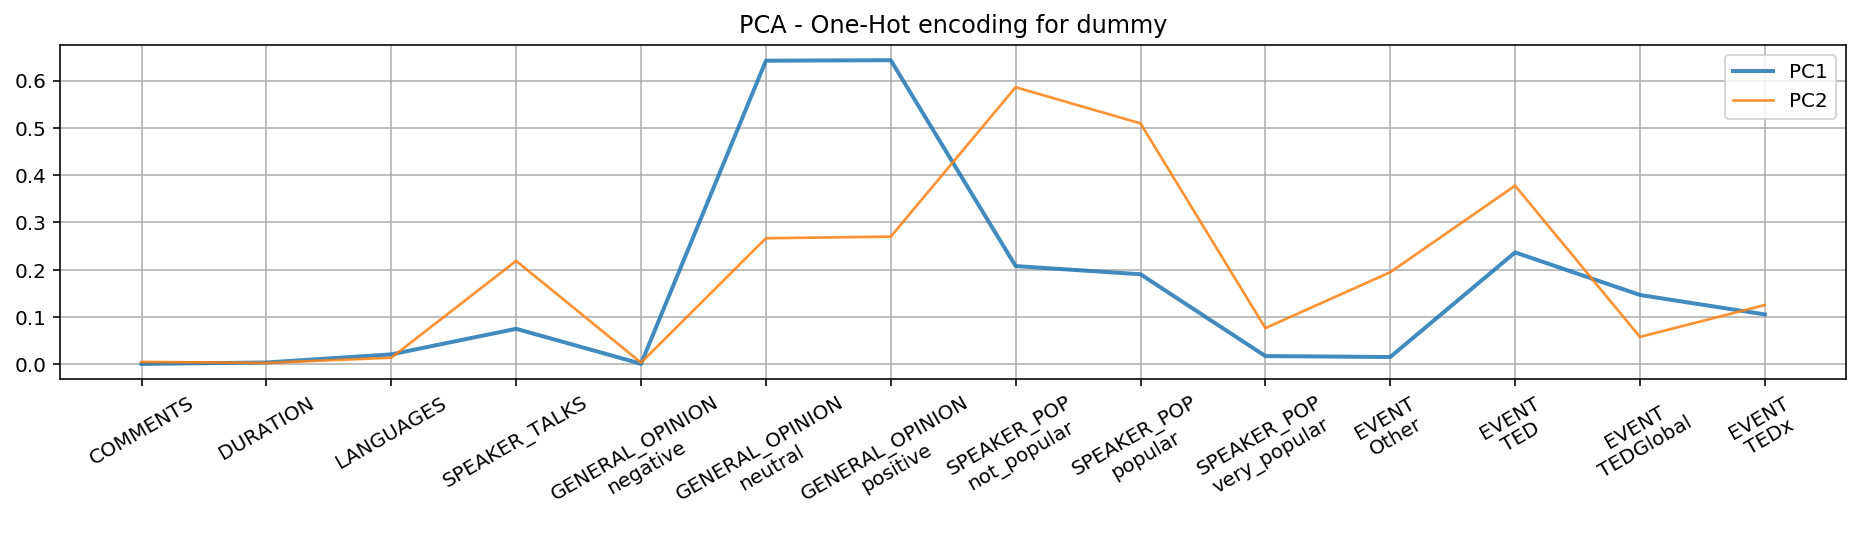

In [55]:
# ----------------------------- Apply PCA  (after one-hot encoding) ----------------------------------------------------
n_comp = 3
pca = PCA(n_components=n_comp)
pca_values = pca.fit_transform(X_train)
components_names = ['PC' + str(i+1) for i in range(n_comp)]
df_pca = pd.DataFrame(pca_values, columns=components_names)

# line plot
components = pca.components_
original_features = X_train.columns.tolist()
u.pca_line_plot(components[:2], original_features, title=" - One-Hot encoding for dummy")

Para mejorar la calidad de los datos utilizados se decide **ponderar las variables dummy** entre el número de categorías de cada variable original. De este modo, si una variable categórica tiene N categorías, los 1s se codificarán como **1/N^x**. Reducimos así la variabilidad que aportan las variables dummies. 

Valores de las variables dummy antes de aplicar la conversión:

In [56]:
X_train.iloc[:3, 4:].head()

,GENERAL_OPINION-negative,GENERAL_OPINION-neutral,GENERAL_OPINION-positive,SPEAKER_POP-not_popular,SPEAKER_POP-popular,SPEAKER_POP-very_popular,EVENT-Other,EVENT-TED,EVENT-TEDGlobal,EVENT-TEDx
0,0,0,1,0,0,1,0,1,0,0
1,0,0,1,0,1,0,0,1,0,0
2,0,0,1,0,0,1,0,1,0,0


Como resultado de aplicar la **conversión descrita** se obtienen las siguientes **variables dummy**:

In [57]:
# Scale dummy variables in order to reduce computed distances 
# scale one-hot encoding dummies
X_train2, X_test2 = u.scale_dummies(X_train, X_test, x_exp=1.7)
X_train2.iloc[:3, 4:].head()

,GENERAL_OPINION-negative,GENERAL_OPINION-neutral,GENERAL_OPINION-positive,SPEAKER_POP-not_popular,SPEAKER_POP-popular,SPEAKER_POP-very_popular,EVENT-Other,EVENT-TED,EVENT-TEDGlobal,EVENT-TEDx
0,0.0,0.0,0.154488,0.0,0.000000,0.154488,0.0,0.094732,0.0,0.0
1,0.0,0.0,0.154488,0.0,0.154488,0.000000,0.0,0.094732,0.0,0.0
2,0.0,0.0,0.154488,0.0,0.000000,0.154488,0.0,0.094732,0.0,0.0


Por defecto el valor de x es 2, aunque es un hiperparámetro con el que se puede jugar. De hecho, el mejor resultado del modelo se ha obtenido con x igual a 1,7.

Volvemos a calcular PCA y observamos el resultado:

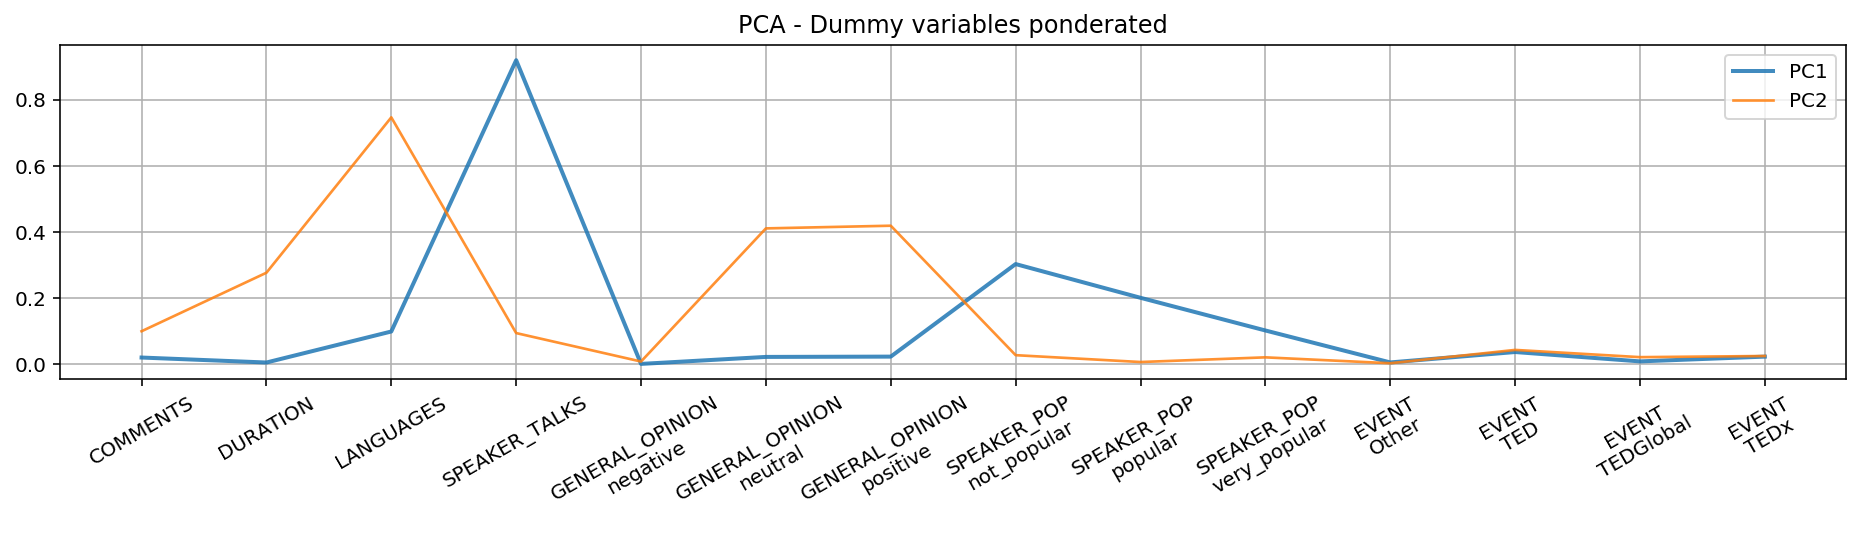

In [58]:
# ----------------------------- Apply PCA  (after dummy variables ponderated) ------------------------------------------
n_comp = 3
pca = PCA(n_components=n_comp)
pca_values = pca.fit_transform(X_train2)
components_names = ['PC' + str(i+1) for i in range(n_comp)]
df_pca = pd.DataFrame(pca_values, columns=components_names)

# line plot
components = pca.components_
original_features = X_train2.columns.tolist()
u.pca_line_plot(components[:2], original_features, title=" - Dummy variables ponderated")

En este caso se observa que las componentes **PC1 y PC2** ahora sí **tienen en cuenta las variables numéricas**, en concreto las variables `LANGUAGES` y `SPEAKER_TALKS`. 

Una vez aplicada la conversión, se vuelve a entrenar el modelo, con la nueva conversión de los datos. El resultado obtenido y la comparativa con el resultado anterior se muestran acontinuación.

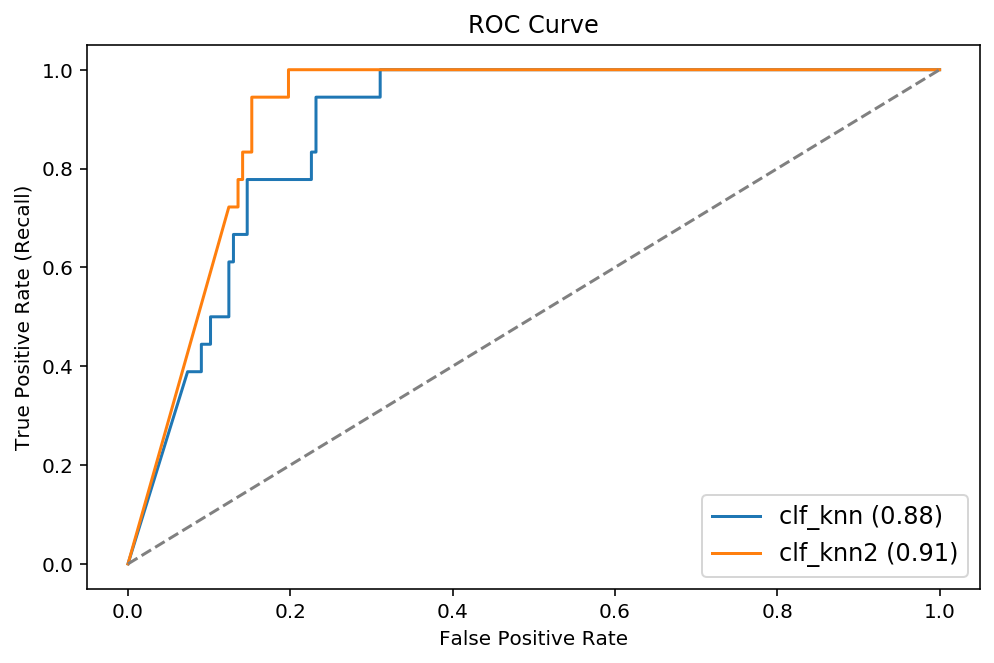

In [59]:
# train model
clf_knn2 = KNeighborsClassifier(n_neighbors=5, weights='distance').fit(X_train2, y_train.values.ravel())
# get estimation
pred_values = clf_knn2.predict(X_test2)
y_pred_knn2 = pd.DataFrame(pred_values, columns=y_train.columns)
# convert string categories to 0 or 1
y_pred_knn2 = y_pred_knn2.replace(mapping_y)

# store model
models['clf_knn2'] = {'clf': clf_knn2, 'X_test': X_test2, 'y_pred': y_pred_knn2}

# get metrics for requested models and plot their ROC curve/curves
models_metrics = u.get_ROC_metrics(models, y_test)
u.plot_ROC(models_metrics, figsize=(8, 5))

Se observa una clara **mejoría que viene principalmente por el ajuste del hyperparámetro que pondera las variables dummy**. Este parámetro **condiciona** de forma directa las influencia de las **distancias** entre variables categóricas.

#### 4.1.1 KNN: Ajuste de hiperparámetros

El modelo knn permite ajustar el numero de vecinos a considerar a la hora de realizar la predicción de una nueva muestra.
Para estudiar la influencia del numero de vecinos k, se han entrenado modelos variando el valor de **k de 1 a 30** y calculando la **tasa de error** (valor promedio del numero de muestras cuya estimación es errónea) y **recall**.

Posteriormente se ha visualizado como varía la tasa de error y se ha seleccionado un valor de k, que mejore las prestaciones de k =5, pero que no sea muy grande, pues complica el cómputa para nuevas muestras.

Text(9, 0.6, 'K = 9')

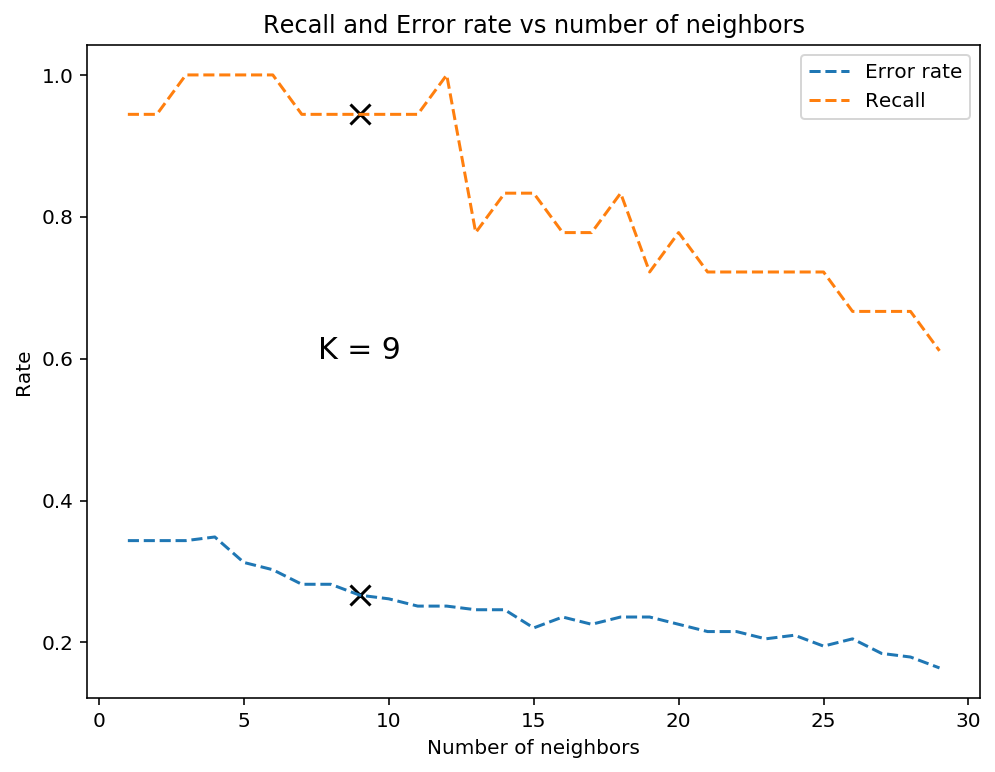

In [60]:
x = []
error_rate = []
recall = []

for k in range(1, 30, 1):
    clf_knn = KNeighborsClassifier(n_neighbors=k, weights='distance').fit(X_train, y_train.values.ravel())
    pred_values = clf_knn.predict(X_test)
    y_pred_knn = pd.DataFrame(pred_values, columns=y_train.columns)
    y_pred = y_pred_knn.replace(mapping_y)
    # compute error rate
    error_rate.append(np.mean(y_pred != y_test))
    recall.append(skm.recall_score(y_test, y_pred))
    x.append(k)

plt.figure(figsize=(8,6))
plt.plot(x, error_rate, linestyle='--', label='Error rate')
plt.plot(x, recall, linestyle='--', label='Recall')
plt.xlabel("Number of neighbors")
plt.ylabel("Rate")
plt.title("Recall and Error rate vs number of neighbors")
plt.legend()

selected_k = 9
plt.scatter(x[selected_k-1], error_rate[selected_k-1], marker='x', s=100, c='black')
plt.scatter(x[selected_k-1], recall[selected_k-1], marker='x', s=100, c='black')
plt.text(x=9, y= 0.6, s='K = 9', fontsize=15,  horizontalalignment='center')

Basándonos en dicha curva, **se ha fijado k = 9 como valor de referencia para entrenar el nuevo modelo.**

Con este valor (k = 9), se entrena el modelo que había ofrecido mejores resultados (knn2).

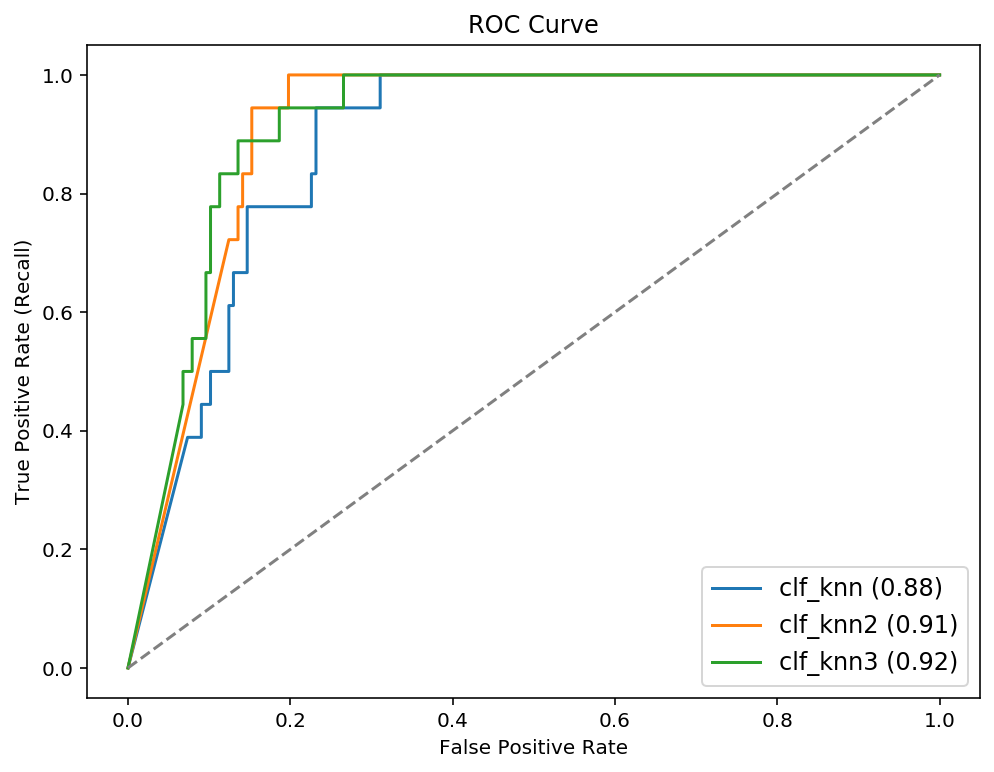

In [31]:
# Apply KNN (n = 9 + distance weighting + dummy scaled)
# train model
clf_knn3 = KNeighborsClassifier(n_neighbors=9, weights='distance').fit(X_train2, y_train.values.ravel())
# get estimation
pred_values = clf_knn3.predict(X_test2)
y_pred_knn3 = pd.DataFrame(pred_values, columns=y_train.columns)
y_pred_knn3 = y_pred_knn3.replace(mapping_y)

# store model
models['clf_knn3'] = {'clf': clf_knn3, 'X_test': X_test2, 'y_pred': y_pred_knn3}

# get metrics for requested models and plot their ROC curve/curves
models_metrics = u.get_ROC_metrics(models, y_test)
u.plot_ROC(models_metrics, figsize=(8, 6))

Este modelo **clf_knn3** sacrifica ligeramente la recall pero mejora el FPR, lo cual es deseable. Se asume que, por el compromiso FPR-Recall que muestra, **ofrece los mejores resultados** del los tres modelos entrenados mediante knn.

### 4.2. GLM: Regresión logística

Dentro de los modelos lineales generalizados podemos encontrar la regresión logística, que será el modelo utilizado en esta sección.
Se han entrenado **tres modelos** distintos donde se ha jugado con los datos de entrada utilizados en la sección anterior (la diferencia entre ambos es la escala en la que se mueven las variables dummy) y con un parámetro que, según lo descrito en la ayuda de la librería, permiten ponderar de forma proporcional para sets de datos desbalanceados.

+ 1. Variables numericas escaladas + one-hot dummies (+ balanceado de datos; class_weigh='balanced')

+ 2. Variables numericas escaladas + one-hot dummies escaladas (+ balanceado de datos; class_weigh='balanced')

+ 2. Variables numericas escaladas + one-hot dummies (SIN balanceado de datos)

In [32]:
# Logistic Regresion: Model (1)
clf_logreg = LogisticRegression(class_weight='balanced', random_state=123, solver='lbfgs').fit(X_train, y_train.values.ravel())
pred_values = clf_logreg.predict(X_test)
y_pred_logreg = pd.DataFrame(pred_values, columns=y_train.columns)
y_pred_logreg = y_pred_logreg.replace(mapping_y)

# store model
models['clf_logreg'] = {'clf': clf_logreg, 'X_test': X_test, 'y_pred': y_pred_logreg}


# Logistic Regresion: Model (2)
clf_logreg2 = LogisticRegression(class_weight='balanced', random_state=123, solver='lbfgs').fit(X_train2, y_train.values.ravel())
pred_values = clf_logreg2.predict(X_test2)
y_pred_logreg2 = pd.DataFrame(pred_values, columns=y_train.columns)
y_pred_logreg2 = y_pred_logreg2.replace(mapping_y)

# store model
models['clf_logreg2'] = {'clf': clf_logreg2, 'X_test': X_test2, 'y_pred': y_pred_logreg2}


# Logistic Regresion: Model (3)
clf_logreg3 = LogisticRegression(class_weight=None, random_state=123, solver='lbfgs').fit(X_train, y_train.values.ravel())
pred_values = clf_logreg3.predict(X_test)
y_pred_logreg3 = pd.DataFrame(pred_values, columns=y_train.columns)
y_pred_logreg3 = y_pred_logreg3.replace(mapping_y)

# store model
models['clf_logreg3'] = {'clf': clf_logreg3, 'X_test': X_test, 'y_pred': y_pred_logreg3}

La comparativa de los tres modelos obtenidos mediante regresión logística se muestra a continuación:

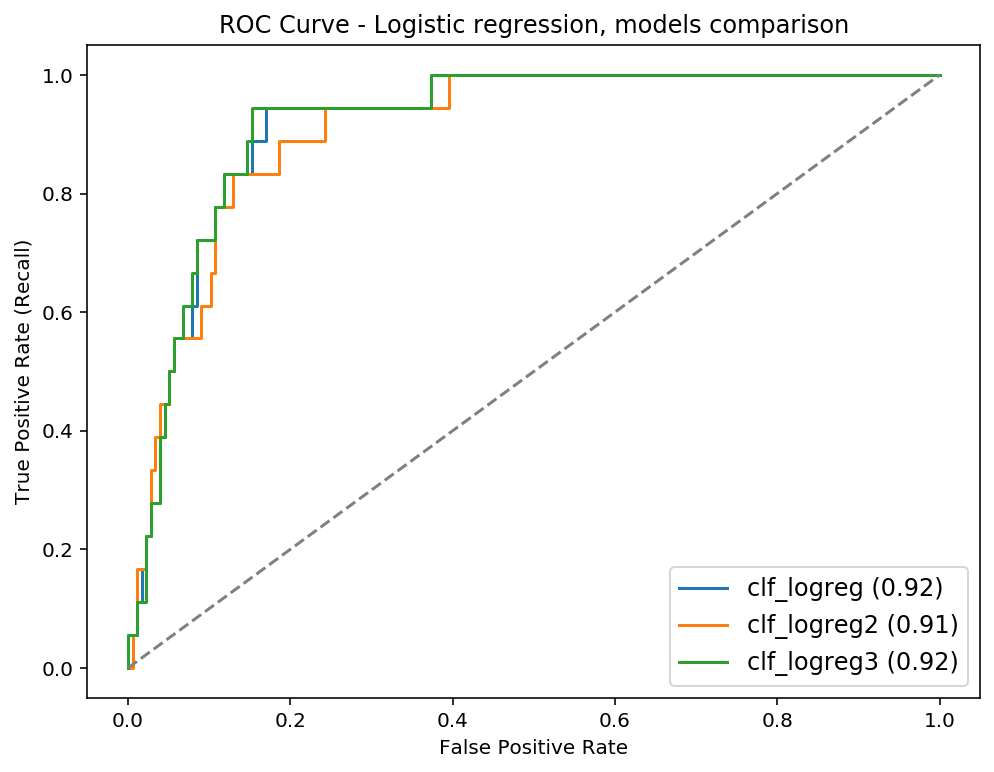

In [33]:
# Compare logistic regression models
models_logreg = u.get_models(models, ['clf_logreg', 'clf_logreg2', 'clf_logreg3'])
models_logreg_metrics = u.get_ROC_metrics(models_logreg, y_test)
u.plot_ROC(models_logreg_metrics, title=' - Logistic regression, models comparison', figsize=(8, 6))

El tercero (**clf_logreg3**) de los modelos es el que **ofrece mejores resultados**. Utiliza los **datos menos tratados y el cómputo más sencillo** (no se utiliza el parámetro class_weigh='balanced' a la hora de instanciar el objeto LogisticRegression, que lleva asociado computos por detrás).

## 5. Comparativa y selección de modelos

### 5.1.1. Comparativa de modelos: KNN vs Regresión Logística

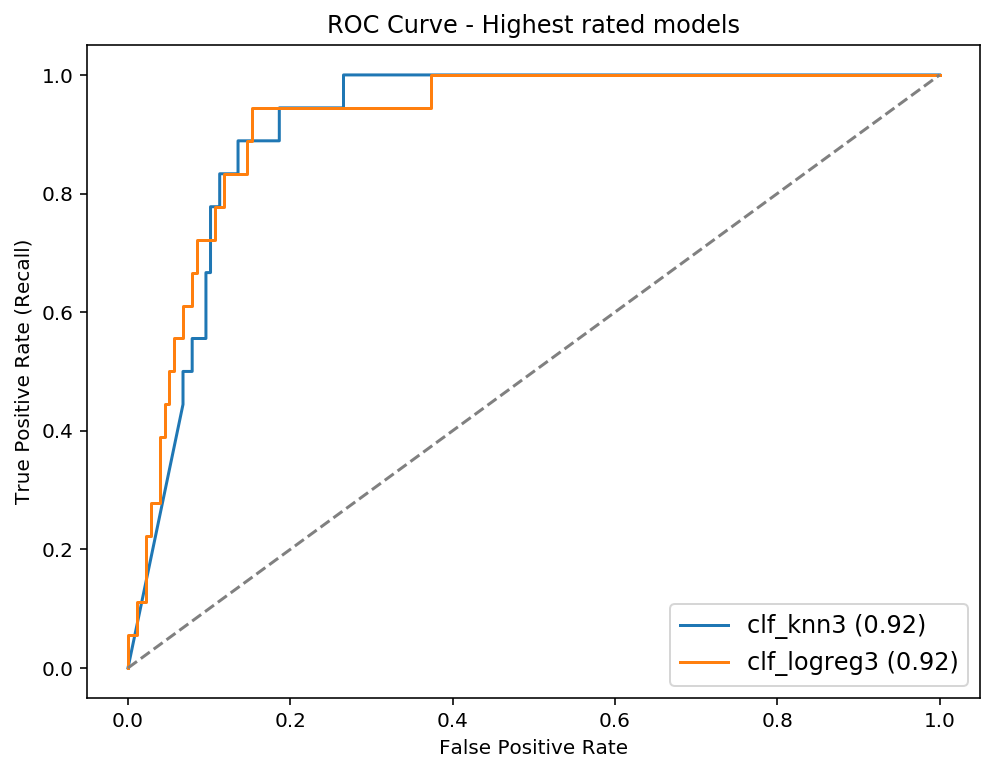

In [36]:
# select models to compare
models_to_compare = u.get_models(models, ['clf_knn3', 'clf_logreg3'])

# retrieve y_test (target values)
df_test = u.read_processing(data_path + '/df_test.csv', threshold=th)
y_test = df_test['VIEWS_CATEGORICAL'].copy()
y_test = y_test.replace(mapping_y)

# get metrics per model and plot comparison
models_metrics = u.get_ROC_metrics(models_to_compare, y_test)
u.plot_ROC(models_metrics, title=" - Highest rated models", figsize=(8, 6))

Ambos modelos ofrece resultados bastante buenos. El modelo **logreg3** ofrecerá mejores prestaciones si se quire lograr un menor FPR con Recall menores de 0.85. Sin embargo, si se desea lograr Recall máximas (1) y se acepta sacrificar el FPR entonces el modelo **knn3** es una mejor opción.


## 5.2 Selección de modelo y umbral

Acontinuación se comparan los mejores clasificadores obtenidos.

In [34]:
# store models
#with open('compared_models.pickle', 'wb') as handle:
#    pickle.dump(models_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# load models
with open('compared_models.pickle', 'rb') as handle:
    loaded_models = pickle.load(handle)

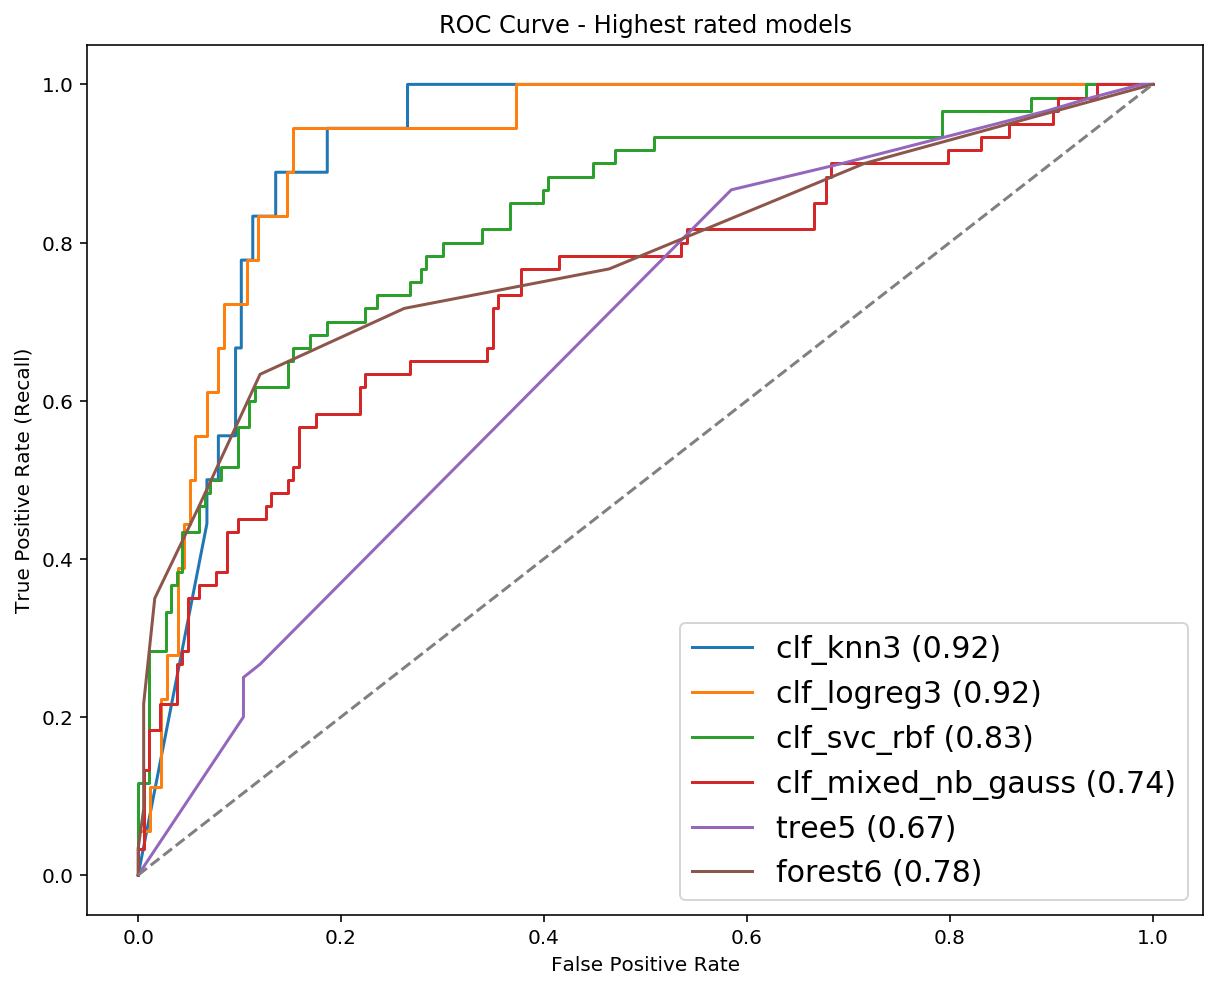

In [35]:
u.plot_ROC(loaded_models, title=" - Highest rated models", figsize=(10, 8), legendsize=15)

El siguiente gráfico (**interactivo**) permite seleccionar el modelo deseado y obtener el `threshold` utilizado para construir cada uno de los punto de las curvas ROC. 

Con este gráfico se puede **seleccionar el modelo** que mejor cumpla los objetivos y **definir un umbral** (añadidos a la curva ROC como metadatos al situarnos sobre ella) que discrimine los datos de una categoría u otra para reajustar la fase de clasificación del modelo.

Prepearamos los cuatro mejores modelos para la comparativa interactiva:

In [48]:
models = list(loaded_models.keys())[:-2]
models_to_compare = {}
for model in models:
    models_to_compare[model] = loaded_models[model]

In [49]:
u.interactive_plot_ROC(models_to_compare, title=" - Highest rated models", figsize=(8, 6), render='browser')